In [118]:
"""TODO
- EDA
- error analysis
    - look at the type1 vs type2 errors
    - manually try to interpret what is it failing to see
- find ways to reduce dimensionality
    - unsupervised learning
    - feature engineering
        - PCA
        - umap
- mine more data
- utilize weights and try first iteration of model
"""

'TODO\n- EDA\n- error analysis\n    - look at the type1 vs type2 errors\n    - manually try to interpret what is it failing to see\n- find ways to reduce dimensionality\n    - unsupervised learning\n    - feature engineering\n        - PCA\n        - umap\n- mine more data\n- utilize weights and try first iteration of model\n'

In [4]:
%reload_ext autoreload
%autoreload 2
import sys  
print(sys.executable)
# Data Handling
import numpy
import pandas

# Data Plotting
import seaborn
import matplotlib.pyplot as plt

# System
from platform import system

# Algorithms
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier

# Imbalance
from imblearn.under_sampling import RandomUnderSampler

# Build
from imblearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Error Analysis
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, f1_score, ConfusionMatrixDisplay

# Hyperparameter
from sklearn.model_selection import GridSearchCV, train_test_split

# Preprocessing
from sklearn.preprocessing import OneHotEncoder

# NN
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# etc
import importlib  # reload modules for updates
import time

/home/beaujb/github/faker-classifier/.venv/bin/python


2022-08-29 08:18:41.043895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 08:18:41.043930: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# intra-package
import champions_dmg_profile
importlib.reload(champions_dmg_profile)
from champions_dmg_profile import champions as gol_champions

In [121]:
RANDOM_STATE = 30  # night night

In [122]:
# Load Dataset
# Get file path
if system() == "Windows":
    filepath = "C:\\Users\\Beau\\Desktop\\ML\\faker\\merged9.csv"
# elif system() == "Linux":
# filepath = ""
else:
    print(f"Unfamiliar OS. Cannot set file path to csv file.")
    exit(1)

# Load csv
print(f'Loading "{filepath}"')
dataframe = pandas.read_csv(filepath)
print(f"Finish loading.")
print(dataframe.shape)

Loading "C:\Users\Beau\Desktop\ML\faker\merged9.csv"
Finish loading.
(987, 65)


In [123]:
# # IF YOU WANT TO BALANCE THE TARGET
# num_wins = dataframe['W/L'].value_counts()[0]
# num_losses = dataframe['W/L'].value_counts()[1]
# print(dataframe['W/L'].value_counts())

# X = dataframe[dataframe['W/L'] == "Win"].sample(num_losses, random_state=RANDOM_STATE)
# dataframe = pandas.concat([X, dataframe[dataframe['W/L'] == "Loss"]])
# print(dataframe.shape)

In [124]:
dataframe.columns

Index(['Date', 'Tournament', 'W/L', 'Side', 'Vs_Team', 'Game_Length',
       'Champion', 'Vs_Champion', 'Kills', 'Deaths', 'Assists', 'KDA',
       'Spells', 'CS', 'Delta_CS', 'Items', 'Date_parsed',
       'tournaments_played', 'date', 'blue_side_team', 'red_side_team',
       'winner', 'blue_side_bans', 'red_side_bans', 'blue_side_picks',
       'red_side_picks', 'blue_side_roster', 'red_side_roster',
       'tournament_curr_total_games', 'tournament_curr_wins',
       'tournament_curr_losses', 'tournament_curr_win_percentage',
       'tournament_type', 'teams_region', 'teammate_role_top',
       'teammate_role_jungle', 'teammate_role_mid', 'teammate_role_adc',
       'teammate_role_support', 'enemy_role_top', 'enemy_role_jungle',
       'enemy_role_mid', 'enemy_role_adc', 'enemy_role_support', 'bans',
       'teammate_top_champion', 'teammate_jungle_champion',
       'teammate_mid_champion', 'teammate_adc_champion',
       'teammate_support_champion', 'opponent_top_champion',
      

In [125]:
dummy = pandas.DataFrame([[4, 9]] * 3, columns=['A', 'B'])
dummy[["test1", "test2"]] = 1, 2
def dummy_func(e):
    print(e.A)
    return 1, 2
dummy[["test1", "test2"]] = dummy.apply(dummy_func, axis=1, result_type="expand")
print(dummy)

4
4
4
   A  B  test1  test2
0  4  9      1      2
1  4  9      1      2
2  4  9      1      2


In [126]:
def get_damage_profile_composition(match):
    # get blue side picks
    blue_side_picks = match["blue_side_picks"].split(',')
    # get red side picks
    red_side_picks = match["red_side_picks"].split(',')

    # get blue picks info with comprehension
    blue_team_info = {champ: gol_champions[champ] for champ in blue_side_picks}
    # get red picks info with comprehension
    red_team_info = {champ: gol_champions[champ] for champ in red_side_picks}

    # calculate weights
    # sum DPM
    sum_blue_dpm = sum((info["DPM"] for info in blue_team_info.values()))
    for info in blue_team_info.values():
        curr_champ_dpm = info["DPM"]
        info["weight"] = curr_champ_dpm / sum_blue_dpm
    sum_red_dpm = sum((info["DPM"] for info in red_team_info.values()))
    for info in red_team_info.values():
        curr_champ_dpm = info["DPM"]
        info["weight"] = curr_champ_dpm / sum_red_dpm

    blue_physical_damage_perc = sum(info["weight"] * info["physical_damage"] for info in blue_team_info.values())
    blue_magic_damage_perc = sum(info["weight"] * info["magic_damage"] for info in blue_team_info.values())
    blue_true_damage_perc = sum(info["weight"] * info["true_damage"] for info in blue_team_info.values())
    red_physical_damage_perc = sum(info["weight"] * info["physical_damage"] for info in red_team_info.values())
    red_magic_damage_perc = sum(info["weight"] * info["magic_damage"] for info in red_team_info.values())
    red_true_damage_perc = sum(info["weight"] * info["true_damage"] for info in red_team_info.values())

    return (blue_physical_damage_perc, blue_magic_damage_perc, blue_true_damage_perc,
            red_physical_damage_perc, red_magic_damage_perc, red_true_damage_perc)

# dataframe[["blue_physical_damage_perc",
#            "blue_magic_damage_perc",
#            "blue_true_damage_perc"]] = dataframe.apply(get_damage_profile_composition, axis=1, result_type="expand")

dataframe[["blue_physical_damage_perc",
           "blue_magic_damage_perc",
           "blue_true_damage_perc",
           "red_physical_damage_perc",
           "red_magic_damage_perc",
           "red_true_damage_perc"]] = dataframe.apply(get_damage_profile_composition, axis=1, result_type="expand")


In [127]:
# EDA
print(dataframe.sort_values(["blue_physical_damage_perc"], ascending=False).head()[["blue_side_picks", "blue_physical_damage_perc"]])
print(dataframe.sort_values(["blue_physical_damage_perc"]).head()[["blue_side_picks", "blue_physical_damage_perc"]])
print(dataframe.sort_values(["red_physical_damage_perc"], ascending=False).head()[["red_side_picks", "red_physical_damage_perc"]])
print(dataframe.sort_values(["red_physical_damage_perc"]).head()[["red_side_picks", "red_physical_damage_perc"]])

                       blue_side_picks  blue_physical_damage_perc
46        Renekton,Vi,Zed,Caitlyn,Sona                  75.293968
352     Jayce,Olaf,Varus,Caitlyn,Karma                  72.850969
900      Jayce,Diana,Lucian,Senna,Sett                  71.926300
673  Jayce,Elise,Aatrox,Lucian,Alistar                  71.042842
588      Gnar,Kha'Zix,Lulu,Xayah,Rakan                  70.728223
                           blue_side_picks  blue_physical_damage_perc
172           Maokai,Nunu,Azir,Corki,Annie                  10.585571
187   Maokai,Evelynn,Viktor,Corki,Nautilus                  12.585083
193  Maokai,Evelynn,Cassiopeia,Corki,Janna                  13.080669
192           Fizz,Gragas,Ryze,Corki,Janna                  14.542857
189         Fizz,Ekko,Viktor,Corki,Alistar                  14.805527
                                red_side_picks  red_physical_damage_perc
402         Shen,Lee Sin,Jayce,Jhin,Tahm Kench                 74.323438
310              Irelia,Graves,Varus,A

In [128]:
# EDA
print(dataframe.sort_values(["blue_magic_damage_perc"], ascending=False).head()[["blue_side_picks", "blue_magic_damage_perc"]])
print(dataframe.sort_values(["blue_magic_damage_perc"]).head()[["blue_side_picks", "blue_magic_damage_perc"]])
print(dataframe.sort_values(["red_magic_damage_perc"], ascending=False).head()[["red_side_picks", "red_magic_damage_perc"]])
print(dataframe.sort_values(["red_magic_damage_perc"]).head()[["red_side_picks", "red_magic_damage_perc"]])

                           blue_side_picks  blue_magic_damage_perc
172           Maokai,Nunu,Azir,Corki,Annie               86.664192
187   Maokai,Evelynn,Viktor,Corki,Nautilus               84.543800
193  Maokai,Evelynn,Cassiopeia,Corki,Janna               84.133032
192           Fizz,Gragas,Ryze,Corki,Janna               82.190458
189         Fizz,Ekko,Viktor,Corki,Alistar               81.976647
                        blue_side_picks  blue_magic_damage_perc
586      Irelia,Camille,Yasuo,Ashe,Nami               20.062142
352      Jayce,Olaf,Varus,Caitlyn,Karma               20.820044
46         Renekton,Vi,Zed,Caitlyn,Sona               20.959126
900       Jayce,Diana,Lucian,Senna,Sett               22.287181
87   Renekton,Lee Sin,Lulu,Twitch,Leona               23.693652
                              red_side_picks  red_magic_damage_perc
45            Rumble,Elise,Gragas,Corki,Sona              87.127608
147    Dr. Mundo,Rek'Sai,Xerath,Corki,Veigar              82.822056
175  Rumbl

In [129]:
# EDA
print(dataframe.sort_values(["blue_true_damage_perc"], ascending=False).head()[["blue_side_picks", "blue_true_damage_perc"]])
print(dataframe[["blue_side_picks", "blue_true_damage_perc"]].sort_values(["blue_true_damage_perc"]).head())
print(dataframe.sort_values(["red_true_damage_perc"], ascending=False).head()[["red_side_picks", "red_true_damage_perc"]])
print(dataframe[["red_side_picks", "red_true_damage_perc"]].sort_values(["red_true_damage_perc"]).head())

                     blue_side_picks  blue_true_damage_perc
430      Galio,Olaf,Ahri,Twitch,Lulu              17.189016
39   Elise,Jarvan IV,Ahri,Vayne,Nami              16.584649
73   Shyvana,Olaf,Gragas,Vayne,Annie              16.310880
175   Maokai,Sejuani,Ahri,Vayne,Nunu              15.384286
71   Renekton,Olaf,Gragas,Vayne,Nami              15.238530
                              blue_side_picks  blue_true_damage_perc
4        Kennen,Nasus,Jayce,Miss Fortune,Sona               1.840656
387        Maokai,Rengar,Ryze,Jhin,Tahm Kench               1.939546
381  Maokai,Kha'Zix,Cassiopeia,Varus,Malzahar               2.028438
393           Maokai,Rengar,Viktor,Jhin,Kayle               2.140816
15             Elise,Nasus,Orianna,Varus,Lulu               2.156105
                        red_side_picks  red_true_damage_perc
222  Fiora,Elise,Lulu,Vayne,Tahm Kench             17.801733
30             Shen,Vi,Ahri,Vayne,Sona             15.373918
950   Gwen,Viego,LeBlanc,Vayne,Trundle     

In [130]:
# cols_to_use = ['Side', 'tournament_curr_win_percentage', 'teams_region', 'teammate_top_champion','teammate_jungle_champion','teammate_mid_champion','teammate_adc_champion','teammate_support_champion','opponent_top_champion','opponent_jungle_champion','opponent_mid_champion','opponent_adc_champion','opponent_support_champion']
cols_to_use = ['Side', 'tournament_curr_win_percentage', 'teams_region', 'teammate_role_top','teammate_role_jungle','teammate_role_mid','teammate_role_adc','teammate_role_support','enemy_role_top','enemy_role_jungle','enemy_role_mid','enemy_role_adc','enemy_role_support', 'tournament_type', 'blue_physical_damage_perc', 'blue_magic_damage_perc', 'blue_true_damage_perc', 'red_physical_damage_perc', 'red_magic_damage_perc', 'red_true_damage_perc']

X = dataframe[cols_to_use]

y = dataframe["W/L"]
def transform_game_result(game_result):
    if game_result.lower() == "win":
        return 1
    elif game_result.lower() == "loss":
        return 0
    else:
        raise ValueError("\"W/L\" column has invalid values")
y = y.transform(transform_game_result)

In [131]:

# Separate dataset in train, dev(cv), test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=RANDOM_STATE)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, train_size=0.75, test_size=0.25, random_state=RANDOM_STATE)

# Get categorical cols
categorical_cols = [col for col in X_train.columns
                    if X_train[col].dtype == "object"]
print(f"categorical_cols = {categorical_cols}\n")
# Get numerical cols
numerical_cols = [col for col in X_train.columns
                  if X_train[col].dtype in ["int64", "float64"]]
print(f"numerical_cols = {numerical_cols}")

categorical_cols = ['Side', 'teams_region', 'teammate_role_top', 'teammate_role_jungle', 'teammate_role_mid', 'teammate_role_adc', 'teammate_role_support', 'enemy_role_top', 'enemy_role_jungle', 'enemy_role_mid', 'enemy_role_adc', 'enemy_role_support', 'tournament_type']

numerical_cols = ['tournament_curr_win_percentage', 'blue_physical_damage_perc', 'blue_magic_damage_perc', 'blue_true_damage_perc', 'red_physical_damage_perc', 'red_magic_damage_perc', 'red_true_damage_perc']


In [132]:
print(f"Before the pipeline, the shape of X_train is {X_train.shape}")

Before the pipeline, the shape of X_train is (591, 20)


In [133]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [134]:
# Establish baseline performance
BASELINE_PERFORMANCE = 0.65  # taken from baseline_performance.txt

In [135]:
# Create list of classifiers to test

"""
In this example, we opted for mostly tree-based and straight forward linear algorithms
This was mostly due to 2 things:
1. A mix of categorical and numerical values with some degree of outliers, so looking for techniques that could handle both categorical and numerical data
without being overly sensitive to outliers
2. Speed. We did have to work through this rather quickly, so we needed algorithms we knew could run quickly-ish.
"""

classifiers = [
    XGBClassifier(random_state=RANDOM_STATE, categorical_feature=True), 
    LGBMClassifier(is_unbalance=True, random_state=RANDOM_STATE), 
    RandomForestClassifier(random_state=RANDOM_STATE), ExtraTreesClassifier(random_state=RANDOM_STATE),
    GradientBoostingClassifier(random_state=RANDOM_STATE), DecisionTreeClassifier(random_state=RANDOM_STATE), ExtraTreeClassifier(random_state=RANDOM_STATE),
    LogisticRegression(random_state=RANDOM_STATE),
    RidgeClassifier(random_state=RANDOM_STATE)
]

In [136]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
brf_model = BalancedRandomForestClassifier(random_state=RANDOM_STATE)
bb_model = BalancedBaggingClassifier(random_state=RANDOM_STATE)
xgb_model = XGBClassifier(random_state=RANDOM_STATE)


In [137]:
# Undersampling
under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
rf_model = make_pipeline(under_sampler, rf_model)
brf_model = make_pipeline(under_sampler, brf_model)
bb_model = make_pipeline(under_sampler, bb_model)
xgb_model = make_pipeline(under_sampler, xgb_model)

In [138]:
# def create_nn_model():
#     nn_model = keras.Sequential([
#         layers.Dense(512, activation='relu', input_shape=[559]),
#         layers.Dropout(rate=0.5),
#         layers.BatchNormalization(),
#         layers.Dense(512, activation='relu'),
#         layers.Dropout(rate=0.5),
#         layers.BatchNormalization(),
#         # layers.Dense(512, activation='relu'),
#         # layers.Dropout(rate=0.1),
#         # layers.BatchNormalization(),
#         # layers.Dense(512, activation='relu'),
#         # layers.Dropout(rate=0.1),
#         # layers.BatchNormalization(),
#         layers.Dense(1, activation='sigmoid'),
#     ])
#     nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
#     return nn_model
# early_stopping = keras.callbacks.EarlyStopping(
#     patience=30,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [139]:
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

brf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', brf_model)
])

bb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', bb_model)
])

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

In [140]:
# nn_model = KerasClassifier(build_fn=create_nn_model, verbose=0)
# nn_pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('model', nn_model)
# ])

In [141]:
# vscode the window has crashed reason oom 536870904
# rf_params = [{
#     "model__n_estimators": [25, 50, 75],
#     "model__max_depth": [5, 10, 15, 20, 25, 30],
#     "model__max_samples": [0.2, 0.4, 0.6, 0.8],

#     # "max_leaf_nodes": []
# }]
# IF RF_MODEL IS A PIPELINE, NEED TO ADD PREFIXES
# rf_params = [{
#     "model__randomforestclassifier__n_estimators": [15, 25, 35],
#     "model__randomforestclassifier__max_depth": [3, 5, 8],
#     "model__randomforestclassifier__max_samples": [0.5, 0.6, 0.7],
#     "model__randomforestclassifier__class_weight": ["balanced"],

#     # "max_leaf_nodes": []
# }]
rf_params = [{
    "model__randomforestclassifier__n_estimators": [25],
    "model__randomforestclassifier__max_depth": [8],
    "model__randomforestclassifier__max_samples": [0.6],
    "model__randomforestclassifier__class_weight": ["balanced"],

    # "max_leaf_nodes": []
}]

brf_params = [{
    "model__balancedrandomforestclassifier__n_estimators": [25],
    "model__balancedrandomforestclassifier__max_depth": [8],
    "model__balancedrandomforestclassifier__max_samples": [0.6],
    "model__balancedrandomforestclassifier__class_weight": ["balanced"],

    # "max_leaf_nodes": []
}]
bb_params = [{
    "model__balancedbaggingclassifier__n_estimators": [15],
    "model__balancedbaggingclassifier__max_samples": [0.6],

    # "max_leaf_nodes": []
}]

# IF XGB_MODEL IS A PIPELINE, NEED TO ADD PREFIXES
xgb_params = [{
    'model__xgbclassifier__alpha': [1],
    'model__xgbclassifier__lambda': [1],
    'model__xgbclassifier__learning_rate': [0.5],
    'model__xgbclassifier__max_delta_step': [3],
    'model__xgbclassifier__max_depth': [5],
    'model__xgbclassifier__min_child_weight': [10],
    'model__xgbclassifier__min_split_loss': [1],
    'model__xgbclassifier__subsample': [0.5],
    'model__xgbclassifier__class_weight': ["balanced"],
}]
# xgb_params = [{
#     'model__alpha': [1],
#     'model__lambda': [1],
#     'model__learning_rate': [0.5],
#     'model__max_delta_step': [3],
#     'model__max_depth': [5],
#     'model__min_child_weight': [10],
#     'model__min_split_loss': [1],
#     'model__subsample': [0.5]
# }]
# ~10 mins
# xgb_params = [{
#     # Prevents overfitting
#     "model__learning_rate": [0.5, 0.7],
#     "model__max_depth": [5, 10,15],
#     "model__subsample": [0.5, 0.6],
#     # More conservative algorithm
#     "model__min_split_loss": [1, 10],
#     "model__min_child_weight": [1, 10],
#     "model__max_delta_step": [3, 9],
#     "model__lambda": [1, 10],
#     "model__alpha": [1, 10],
#     # Other
#     # "max_leaves": [],
# }]
# # This crashes my laptop
# xgb_params = [{
#     # Prevents overfitting
#     "model__learning_rate": [0.5, 0.7, 0.9],
#     "model__max_depth": [5, 10,15],
#     "model__subsample": [0.4, 0.6, 0.8],
#     # More conservative algorithm
#     "model__min_split_loss": [0.1, 1, 10],
#     "model__min_child_weight": [0.1, 1, 10],
#     "model__max_delta_step": [3, 6, 9],
#     "model__lambda": [0.1, 1, 10],
#     "model__alpha": [0.1, 1, 10],
#     # Other
#     # "max_leaves": [],
# }]
# # Overnight: ~6.25 hours
# xgb_params = [{
#     # Prevents overfitting
#     "model__learning_rate": [0.3, 0.5, 0.7, 0.8, 0.9],
#     "model__max_depth": [5, 10, 15, 20, 25, 30],
#     "model__subsample": [0.2, 0.4, 0.6, 0.8],
#     # More conservative algorithm
#     "model__min_split_loss": [0.01, 0.1, 1, 10, 100],
#     "model__min_child_weight": [0.01, 0.1, 1, 10, 100],
#     "model__max_delta_step": [3, 6, 9],
#     "model__lambda": [0.01, 0.1, 1, 10, 100],
#     "model__alpha": [0.01, 0.1, 1, 10, 100],
#     # Other
#     # "max_leaves": [],
# }]

def calculate_runtime(params, seconds_per_model=0.25, cv_folds=5):
    """
    For reference:
    Every 36,000 permutations => 1 hour at 0.1 secs/model
    5 hours at 0.1 secs/model is 180,000 total permutations
    6 hours at 0.1 secs/model is 216,000 total permutations
    7 hours at 0.1 secs/model is 252,000 total permutations
    8 hours at 0.1 secs/model is 288,000 total permutations
    """
    params = params[0]
    total_permutations = 1
    for param, lst in params.items():
        total_permutations *= len(lst)
    
    total_permutations *= cv_folds
    time = ((total_permutations * seconds_per_model) / 60)

    return total_permutations, time

rf_permutations, rf_runtime = calculate_runtime(rf_params)
xgb_permutations, xgb_runtime = calculate_runtime(xgb_params)
print(f"RF - GridSearchCV has {rf_permutations} permutations and will take {rf_runtime:.2f} minutes (={rf_runtime/60:.2f})")
print(f"XGB - GridSearchCV has {xgb_permutations} permutations and will take {xgb_runtime:.2f} minutes (={xgb_runtime/60:.2f} hours)")


RF - GridSearchCV has 5 permutations and will take 0.02 minutes (=0.00)
XGB - GridSearchCV has 5 permutations and will take 0.02 minutes (=0.00 hours)


In [155]:
# Function to test multiple classifiers
under_sampler = RandomUnderSampler(random_state=RANDOM_STATE)

params = {
    "BalancedBaggingClassifier": [{
        "model__balancedbaggingclassifier__n_estimators": [15],
        "model__balancedbaggingclassifier__max_samples": [0.6],

        # "max_leaf_nodes": []
    }],
    "BalancedRandomForestClassifier": [{
        "model__balancedrandomforestclassifier__n_estimators": [25],
        "model__balancedrandomforestclassifier__max_depth": [8],
        "model__balancedrandomforestclassifier__max_samples": [0.6],
        "model__balancedrandomforestclassifier__class_weight": ["balanced"],

        # "max_leaf_nodes": []
    }],
    "DecisionTreeClassifier": [{
        "model__decisiontreeclassifier__max_depth": [8],
        "model__decisiontreeclassifier__class_weight": ["balanced"],
    }],
    "ExtraTreeClassifier": [{
        "model__extratreeclassifier__max_depth": [8],
        "model__extratreeclassifier__class_weight": ["balanced"],
    }],
    "ExtraTreesClassifier": [{
        "model__extratreesclassifier__n_estimators": [25],
        "model__extratreesclassifier__max_depth": [8],
        "model__extratreesclassifier__max_samples": [0.6],
        "model__extratreesclassifier__bootstrap": [True],  # this must be True if you want to use max_samples
        "model__extratreesclassifier__class_weight": ["balanced"],
    }],
    "GradientBoostingClassifier": [{
        "model__gradientboostingclassifier__n_estimators": [25],
        "model__gradientboostingclassifier__max_depth": [8],
    }],
    "LGBMClassifier": [{
        "model__lgbmclassifier__n_estimators": [25],
        "model__lgbmclassifier__max_depth": [8],
        "model__lgbmclassifier__class_weight": ["balanced"],
    }],
    "LogisticRegression": [{
        "model__logisticregression__class_weight": ["balanced"],
    }],
    "RandomForestClassifier": 
        [{
        "model__randomforestclassifier__n_estimators": [25],
        "model__randomforestclassifier__max_depth": [8],
        "model__randomforestclassifier__max_samples": [0.6],
        "model__randomforestclassifier__class_weight": ["balanced"],

        # "max_leaf_nodes": []
    }],
    "RidgeClassifier": [{
        "model__ridgeclassifier__class_weight": ["balanced"],
    }],
    "XGBClassifier": [{
        'model__xgbclassifier__alpha': [1],
        'model__xgbclassifier__lambda': [1],
        'model__xgbclassifier__learning_rate': [0.5],
        'model__xgbclassifier__max_delta_step': [3],
        'model__xgbclassifier__max_depth': [5],
        'model__xgbclassifier__min_child_weight': [10],
        'model__xgbclassifier__min_split_loss': [1],
        'model__xgbclassifier__subsample': [0.5],
        'model__xgbclassifier__class_weight': ["balanced"],
    }],
}
def test_classifiers(train_data, train_classes, test_data, test_classes, classifiers):
    
    res = {}

    for clf in classifiers:
        name = clf.__class__.__name__

        print("Now training {}...".format(name))

        start_time = time.time()

        us_pipeline = make_pipeline(under_sampler, clf)
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', us_pipeline)
        ])

        model = GridSearchCV(pipeline,
                             param_grid=params[name],
                             scoring='f1',
                             cv=5)
                            #  verbose=2)

        model.fit(train_data, train_classes)
        
        acc = round(balanced_accuracy_score(test_classes, model.predict(test_data)), 3)
        f1 = round(f1_score(y_true=test_classes, y_pred = model.predict(test_data), average='weighted'), 3)

        stop_time = time.time()

        time_to_run = round(stop_time - start_time,3)

        print("{} trained in {} with an F1 of : {} and an accuracy of: {}".format(name, time_to_run, f1, acc))

        res[name] = (acc, f1, time_to_run)

    return res
# # Function to test multiple classifiers
# def test_classifiers(train_data, train_classes, test_data, test_classes, classifiers):
    
#     res = {}

#     for clf in classifiers:
#         name = clf.__class__.__name__

#         print("Now training {}...".format(name))

#         start_time = time.time()
#         clf.fit(train_data, train_classes)
        
#         acc = round(balanced_accuracy_score(test_classes, clf.predict(test_data)), 3)
#         f1 = round(f1_score(y_true=test_classes, y_pred = clf.predict(test_data), average='weighted'), 3)

#         stop_time = time.time()

#         time_to_run = round(stop_time - start_time,3)

#         print("{} trained in {} with an F1 of : {} and an accuracy of: {}".format(name, time_to_run, f1, acc))

#         res[name] = (acc, f1, time_to_run)

#     return res

In [156]:
classifier_results = test_classifiers(X_train, y_train, X_dev, y_dev, classifiers)

Now training XGBClassifier...
[22:45:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "categorical_feature", "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "categorical_feature", "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:45:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/s

KeyError: 'LogisticRegression'

In [92]:
rf = GridSearchCV(rf_pipeline,
                      param_grid=rf_params,
                      scoring='f1',
                      cv=5,
                      verbose=2)
brf = GridSearchCV(brf_pipeline,
                      param_grid=brf_params,
                      scoring='f1',
                      cv=5,
                      verbose=2)
bb = GridSearchCV(bb_pipeline,
                      param_grid=bb_params,
                      scoring='f1',
                      cv=5,
                      verbose=2)
xgb = GridSearchCV(xgb_pipeline,
                      param_grid=xgb_params,
                      scoring='f1',
                      cv=5,
                      verbose=2)

In [93]:
# rf_pipeline.fit(X_train, y_train)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END model__randomforestclassifier__class_weight=balanced, model__randomforestclassifier__max_depth=8, model__randomforestclassifier__max_samples=0.6, model__randomforestclassifier__n_estimators=25; total time=   0.5s
[CV] END model__randomforestclassifier__class_weight=balanced, model__randomforestclassifier__max_depth=8, model__randomforestclassifier__max_samples=0.6, model__randomforestclassifier__n_estimators=25; total time=   0.3s
[CV] END model__randomforestclassifier__class_weight=balanced, model__randomforestclassifier__max_depth=8, model__randomforestclassifier__max_samples=0.6, model__randomforestclassifier__n_estimators=25; total time=   0.3s
[CV] END model__randomforestclassifier__class_weight=balanced, model__randomforestclassifier__max_depth=8, model__randomforestclassifier__max_samples=0.6, model__randomforestclassifier__n_estimators=25; total time=   0.3s
[CV] END model__randomforestclassifier__class_weight=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Side',
                                                                          'teams_region',
                                                                          'teammate_role_top',
                                                                          'teammate_role_jungle',
                                                                          'teammate_role_mid',
                                                                          'teammate_role_adc',
                                                         

In [94]:
print(rf.best_score_)
print(rf.best_params_)

0.5787500292005598
{'model__randomforestclassifier__class_weight': 'balanced', 'model__randomforestclassifier__max_depth': 8, 'model__randomforestclassifier__max_samples': 0.6, 'model__randomforestclassifier__n_estimators': 25}


In [95]:
brf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END model__balancedrandomforestclassifier__class_weight=balanced, model__balancedrandomforestclassifier__max_depth=8, model__balancedrandomforestclassifier__max_samples=0.6, model__balancedrandomforestclassifier__n_estimators=25; total time=   0.5s
[CV] END model__balancedrandomforestclassifier__class_weight=balanced, model__balancedrandomforestclassifier__max_depth=8, model__balancedrandomforestclassifier__max_samples=0.6, model__balancedrandomforestclassifier__n_estimators=25; total time=   0.5s
[CV] END model__balancedrandomforestclassifier__class_weight=balanced, model__balancedrandomforestclassifier__max_depth=8, model__balancedrandomforestclassifier__max_samples=0.6, model__balancedrandomforestclassifier__n_estimators=25; total time=   0.6s
[CV] END model__balancedrandomforestclassifier__class_weight=balanced, model__balancedrandomforestclassifier__max_depth=8, model__balancedrandomforestclassifier__max_samples=0.6, 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Side',
                                                                          'teams_region',
                                                                          'teammate_role_top',
                                                                          'teammate_role_jungle',
                                                                          'teammate_role_mid',
                                                                          'teammate_role_adc',
                                                         

In [96]:
bb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=15; total time=   0.2s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=15; total time=   0.2s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=15; total time=   0.2s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=15; total time=   0.3s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=15; total time=   0.5s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=25; total time=   0.8s
[CV] END model__balancedbaggingclassifier__max_samples=0.5, model__balancedbaggingclassifier__n_estimators=25; total time=   0.7s
[CV] END model__balancedbaggin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Side',
                                                                          'teams_region',
                                                                          'teammate_role_top',
                                                                          'teammate_role_jungle',
                                                                          'teammate_role_mid',
                                                                          'teammate_role_adc',
                                                         

In [97]:
# xgb_pipeline.fit(X_train, y_train)
xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[21:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END model__xgbclassifier__alpha=1, model__xgbclassifier__class_weight=balanced, model__xgbclassifier__lambda=1, model__xgbclassifier__learning_rate=0.5, model__xgbclassifier__max_delta_step=3, model__xgbclassifier__max_depth=5, model__xgbclassifier__min_child_weight=10, model__xgbclassifier__min_split_loss=1, model__xgbclassifier__subsample=0.5; total time=   2.2s
[21:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "class_weight" } might not be us

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Side',
                                                                          'teams_region',
                                                                          'teammate_role_top',
                                                                          'teammate_role_jungle',
                                                                          'teammate_role_mid',
                                                                          'teammate_role_adc',
                                                         

In [98]:
# X_temp = numpy.asarray(X_train).astype(numpy.float32)
# nn_pipeline.fit(
#     X_temp, y_train,
#     model__validation_data=(X_test, y_test),
#     model__batch_size=64,
#     model__epochs=1000,
#     model__callbacks=[early_stopping],
#     # model__verbose=0, # hide the output because we have so many epochs
# )

In [99]:
# rf_predict_train = rf_pipeline.predict(X_train)
# rf_predict_test = rf_pipeline.predict(X_test)
rf_predict_train = rf.predict(X_train)
rf_predict_test = rf.predict(X_test)

In [100]:
rf_train_f1_score = f1_score(y_train, rf_predict_train, average="binary")
print(f"The F1 Score for the RF model on the training set is: {rf_train_f1_score * 100:.2f}%")
rf_test_f1_score = f1_score(y_test, rf_predict_test, average="binary")
print(f"The F1 Score for the RF model on the test set  is: {rf_test_f1_score * 100:.2f}%")

The F1 Score for the RF model on the training set is: 75.63%
The F1 Score for the RF model on the test set  is: 60.43%


In [101]:
brf_predict_train = brf.predict(X_train)
brf_predict_test = brf.predict(X_test)

In [102]:
brf_train_f1_score = f1_score(y_train, brf_predict_train, average="binary")
print(f"The F1 Score for the BRF model on the training set is: {brf_train_f1_score * 100:.2f}%")
brf_test_f1_score = f1_score(y_test, brf_predict_test, average="binary")
print(f"The F1 Score for the BRF model on the test set  is: {brf_test_f1_score * 100:.2f}%")

The F1 Score for the BRF model on the training set is: 75.16%
The F1 Score for the BRF model on the test set  is: 59.66%


In [103]:
bb_predict_train = bb.predict(X_train)
bb_predict_test = bb.predict(X_test)

In [104]:
bb_train_f1_score = f1_score(y_train, bb_predict_train, average="binary")
print(f"The F1 Score for the bb model on the training set is: {bb_train_f1_score * 100:.2f}%")
bb_test_f1_score = f1_score(y_test, bb_predict_test, average="binary")
print(f"The F1 Score for the bb model on the test set  is: {bb_test_f1_score * 100:.2f}%")

The F1 Score for the bb model on the training set is: 86.79%
The F1 Score for the bb model on the test set  is: 67.95%


In [105]:
# xgb_predict_train = xgb_pipeline.predict(X_train)
# xgb_predict_test = xgb_pipeline.predict(X_test)
xgb_predict_train = xgb.predict(X_train)
xgb_predict_test = xgb.predict(X_test)

0.5843877151549786
{'model__xgbclassifier__alpha': 1, 'model__xgbclassifier__class_weight': 'balanced', 'model__xgbclassifier__lambda': 1, 'model__xgbclassifier__learning_rate': 0.5, 'model__xgbclassifier__max_delta_step': 3, 'model__xgbclassifier__max_depth': 5, 'model__xgbclassifier__min_child_weight': 10, 'model__xgbclassifier__min_split_loss': 1, 'model__xgbclassifier__subsample': 0.5}


In [106]:
xgb_train_f1_score = f1_score(y_train, xgb_predict_train, average="binary")
print(f"The F1 Score for the XGB model on the training set is: {xgb_train_f1_score * 100:.2f}%")
xgb_test_f1_score = f1_score(y_test, xgb_predict_test, average="binary")
print(f"The F1 Score for the XGB model on the test set  is: {xgb_test_f1_score * 100:.2f}%")

The F1 Score for the XGB model on the training set is: 65.70%
The F1 Score for the XGB model on the test set  is: 63.37%


In [109]:
print(rf.best_score_)
print(brf.best_score_)
print(bb.best_score_)
print(xgb.best_score_)

0.5787500292005598
0.6168303808578155
0.5985062395231887
0.5843877151549786


In [116]:
xgb.feature_names_in_

array(['Side', 'tournament_curr_win_percentage', 'teams_region',
       'teammate_role_top', 'teammate_role_jungle', 'teammate_role_mid',
       'teammate_role_adc', 'teammate_role_support', 'enemy_role_top',
       'enemy_role_jungle', 'enemy_role_mid', 'enemy_role_adc',
       'enemy_role_support', 'tournament_type',
       'blue_physical_damage_perc', 'blue_magic_damage_perc',
       'blue_true_damage_perc', 'red_physical_damage_perc',
       'red_magic_damage_perc', 'red_true_damage_perc'], dtype=object)

In [117]:
print(rf.best_params_)
print(brf.best_params_)
print(bb.best_params_)
print(xgb.best_params_)

{'model__randomforestclassifier__class_weight': 'balanced', 'model__randomforestclassifier__max_depth': 8, 'model__randomforestclassifier__max_samples': 0.6, 'model__randomforestclassifier__n_estimators': 25}
{'model__balancedrandomforestclassifier__class_weight': 'balanced', 'model__balancedrandomforestclassifier__max_depth': 8, 'model__balancedrandomforestclassifier__max_samples': 0.6, 'model__balancedrandomforestclassifier__n_estimators': 25}
{'model__balancedbaggingclassifier__max_samples': 0.6, 'model__balancedbaggingclassifier__n_estimators': 15}
{'model__xgbclassifier__alpha': 1, 'model__xgbclassifier__class_weight': 'balanced', 'model__xgbclassifier__lambda': 1, 'model__xgbclassifier__learning_rate': 0.5, 'model__xgbclassifier__max_delta_step': 3, 'model__xgbclassifier__max_depth': 5, 'model__xgbclassifier__min_child_weight': 10, 'model__xgbclassifier__min_split_loss': 1, 'model__xgbclassifier__subsample': 0.5}


In [226]:
feature_importance_scores = xgb.best_estimator_[1][1].feature_importances_

In [247]:
bar = xgb.best_estimator_[1][1].get_booster().get_score(importance_type="weight")
bar = {k: v for k, v in sorted(bar.items(), key=lambda item: item[1], reverse=True)}
bar

{'f134': 23.0,
 'f31': 22.0,
 'f115': 22.0,
 'f57': 21.0,
 'f87': 19.0,
 'f0': 16.0,
 'f96': 11.0,
 'f121': 11.0,
 'f39': 10.0,
 'f97': 10.0,
 'f127': 10.0,
 'f128': 10.0,
 'f69': 9.0,
 'f40': 8.0,
 'f70': 8.0,
 'f75': 7.0,
 'f64': 6.0,
 'f112': 6.0,
 'f117': 5.0,
 'f19': 4.0,
 'f35': 4.0,
 'f54': 3.0,
 'f66': 3.0,
 'f59': 2.0,
 'f81': 2.0,
 'f92': 2.0,
 'f7': 1.0,
 'f25': 1.0,
 'f133': 1.0}

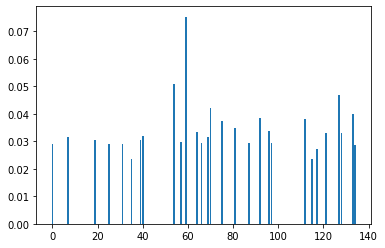

In [194]:
from matplotlib import pyplot
# plot
pyplot.bar(range(len(foo)), foo)
pyplot.show()

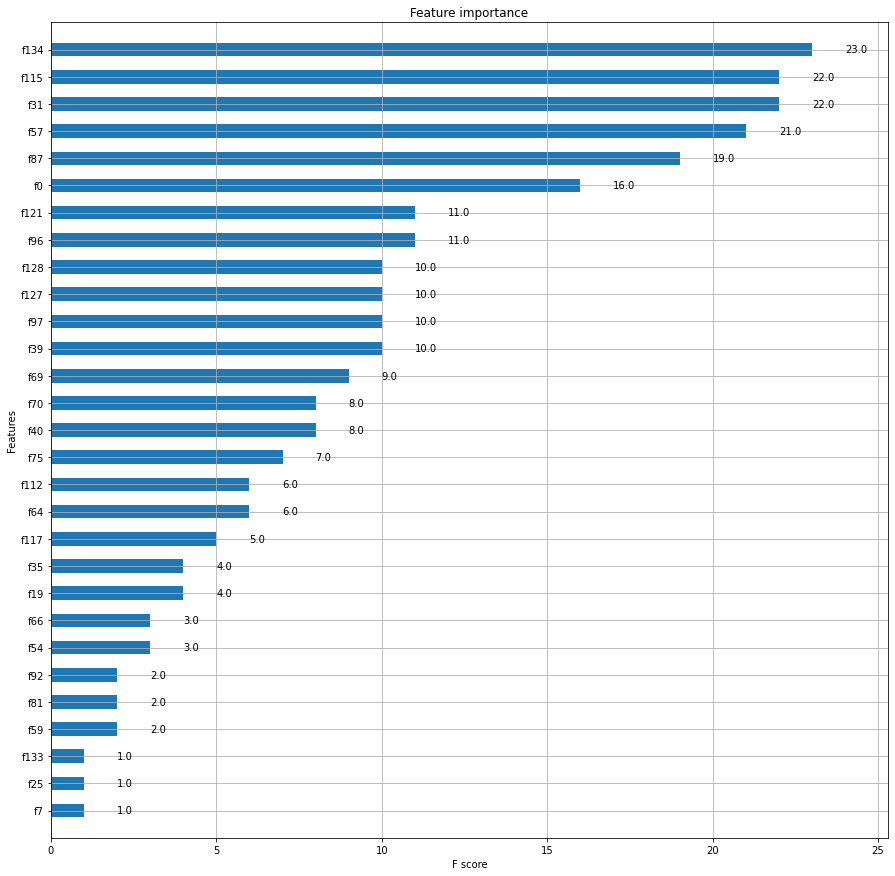

In [241]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(15,15))
# plot_importance(xgb.best_estimator_[1][1])
plot_importance(xgb.best_estimator_[1][1], height=0.5, ax=ax)
# plt.rcParams["figure.figsize"] = (15,15)
plt.show()

In [240]:
# rf_pipeline[0] is the preprocessor object, which has the function get_feature_names_out
# encoded_features = rf_pipeline[0].get_feature_names_out()
# xgb.best_estimator_[0].get_feature_names()
encoded_features = xgb.best_estimator_[0].get_feature_names_out()
foo = {}
for i, f in enumerate(encoded_features):
    # print(f"{i}:{f} has a feature importance score={feature_importance_scores[i]}")
    # foo[{str(f).split("cat__")[1]}] = feature_importance_scores[i]
    foo_name = f'{i}_{str(f).split("cat__")[1]}'
    foo[foo_name] = feature_importance_scores[i]
foo = {k: v for k, v in sorted(foo.items(), key=lambda item: item[1], reverse=True)}
foo

{'59_teammate_role_adc_Sniper': 0.07533526,
 '54_teammate_role_adc_Glasscannon': 0.05071324,
 '127_enemy_role_support_Vanguard': 0.046767734,
 '70_teammate_role_support_Warden': 0.042123064,
 '133_tournament_type_Playoffs': 0.03988716,
 '92_enemy_role_jungle_Vanguard': 0.038308017,
 '112_enemy_role_adc_Glasscannon': 0.037984964,
 '75_enemy_role_top_Diver': 0.037219133,
 '81_enemy_role_top_Vanguard': 0.03493415,
 '96_enemy_role_mid_Battlemage': 0.033676397,
 '64_teammate_role_support_Catcher': 0.033360593,
 '128_enemy_role_support_Warden': 0.03306278,
 '121_enemy_role_support_Catcher': 0.033015564,
 '40_teammate_role_mid_Burst': 0.031845707,
 '69_teammate_role_support_Vanguard': 0.031557817,
 '7_teams_region_Korea': 0.031493984,
 '19_teammate_role_top_Diver': 0.03055621,
 '39_teammate_role_mid_Battlemage': 0.030321889,
 '57_teammate_role_adc_Nimble': 0.02969369,
 '66_teammate_role_support_Enchanter': 0.02949796,
 '97_enemy_role_mid_Burst': 0.02937269,
 '87_enemy_role_jungle_Diver': 0.02

In [3]:
# import joblib
# rf_file = "rf.pkl"
# rf.estimator[0].transformers[0][1]
# rf = joblib.load(rf_file)
# rf_predict_train = rf.predict(X_train)
# rf_predict_test = rf.predict(X_test)
# rf_train_f1_score = f1_score(y_train, rf_predict_train, average="binary")
# rf_test_f1_score = f1_score(y_test, rf_predict_test, average="binary")

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# foo = compute_class_weight('balanced', classes=[1,0], y=y)

Save Model

In [176]:
import save_model
importlib.reload(save_model)

<module 'save_model' from 'c:\\Users\\Beau\\Desktop\\ML\\faker\\save_model.py'>

In [ ]:
# To prove that undersampling is helping
# the std should be very small (comparing with and without undersampling)

# cv_results = rf.cv_results_["split0_test_score"].mean()
cv_results = rf.cv_results_
num_folds = 5
for x in range(num_folds):
    curr = f"split{x}_test_score"
    print(
        f"F1 mean +/- std. dev.: for split={curr}: "
        f"{cv_results[curr].mean():.3f} +/- "
        f"{cv_results[curr].std():.3f}"
    )

In [ ]:
save_model.save_model(rf, "rf_5.pkl", X_train, rf_params[0], rf_test_f1_score, description="added damage profile composition columns")

In [178]:
save_model.save_model(xgb, "xgb_4.pkl", X_train, xgb_params[0], xgb_test_f1_score, description="added damage profile composition columns")

data after append={'models': [{'scores': {'train_score': 0.8069628706898238, 'test_score': 0.7889908256880734}, 'params': {'model__max_depth': 10, 'model__max_samples': 0.6, 'model__n_estimators': 75}, 'columns': ['Side', 'tournament_curr_win_percentage', 'teams_region', 'teammate_top_champion', 'teammate_jungle_champion', 'teammate_mid_champion', 'teammate_adc_champion', 'teammate_support_champion', 'opponent_top_champion', 'opponent_jungle_champion', 'opponent_mid_champion', 'opponent_adc_champion', 'opponent_support_champion'], 'dataset_meta_data': {'shape': [789, 13]}, 'hyperparam_tuning': {'model__n_estimators': [25, 50, 75], 'model__max_depth': [5, 10, 15, 20, 25, 30], 'model__max_samples': [0.2, 0.4, 0.6, 0.8]}, 'file_name': 'rf_0.pkl', 'type': 'RandomForestClassifier', 'versions': {'pandas': '1.3.5', 'numpy': '1.21.6', 'scikit-learn': '1.0.2', 'seaborn': '0.11.2', 'sklearn': '0.0', 'tensorflow': '2.9.1', 'xgboost': '1.6.1'}, 'description': 'first time'}, {'scores': {'train_scor

In [ ]:
# rf_pipeline[0] is the preprocessor object, which has the function get_feature_names_out
# encoded_features = rf_pipeline[0].get_feature_names_out()

In [ ]:
# # This cell did not work initially. VSCode might need to reboot to recognize the newly downloaded graphviz
# estimator = rf_pipeline[1].estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = encoded_features,
#                 class_names = ["Win", "Loss"],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'C:\\Users\\Beau\\Desktop\\ML\\faker\\tree.dot', '-o', 'C:\\Users\\Beau\\Desktop\\ML\\faker\\tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [ ]:
# # Generate a PNG file for one of the trees
# from sklearn import tree
# import matplotlib.pyplot as plt
# fn=encoded_features
# cn=["Win", "Loss"]
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(rf.estimator[1].estimators_[0],
# # tree.plot_tree(rf_pipeline[1].estimators_[0],
#                feature_names = fn, 
#                class_names=cn,
#                filled = True);
# fig.savefig('rf_individualtree.png')
# print("Generated one tree")  # takes about 30 seconds

To reduce overfitting,
A. Add more examples
B. Reduce number of features
C. Increase regularization parameter
D. Trees - reduce depth and other parameters
    - early_stopping_rounds: can use high n_estimators, and then modify this parameter. note: this is a parameter for XGBClassifier.fit()
    - learning_rate: large learning_rate+large n_estimators leads to more accurate models, but takes longer

Error Analysis
    - manually examine 100 examples and see if there is a pattern

Iterative Loop of ML
    Choose Architecture
    Train
    Diagnostics (bias, variance, error analysis)

Baseline Performance    10.6%           10.6%       10.6%
                            +0.2%           +4.4%       +4.4%
Training Error          10.8%           15.0%       15.0%
                            +4.0%           +0.5%       +4.7%
CV Error                14.8%           15.5%       19.7%
                        (High Variance) (High Bias) (High Variance & Bias)

No Hyperparameter Tuning
RF
Baseline Performance    35.0%
                            -35.0%
Training Error          0.00%
                            +22.9%
CV Error                22.9%
                        (High Variance)
XGB
Baseline Performance    35.0%
                            -30.8%
Training Error          4.20%
                            +23.4%
CV Error                27.6%
                        (High Variance)

After Hyperparameter Tuning
RF
Baseline Performance    35.0%
                            -16.0%
Training Error          19.0%
                            +2.10%
CV Error                21.1%
                        (High Variance)


Random Forest Parameters

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

"Prevents overfitting" \
`n_estimators`. default=100. increase => overfitting \
`max_depth`. default=None. increase => overfitting \
`max_samples`. similar to `subsample` for XGB?

Other \
`max_leaf_nodes`. default=None

XGB Parameters

https://xgboost.readthedocs.io/en/stable/parameter.html

"Prevents overfitting" \
`eta` (aka `learning_rate`). default=0.3 \
`max_depth`. default=6. range=[0, infinity]. larger max_depth => overfitting. \
`subsample`. default=1. range=(0,1]

"More conversative" \
`gamma` (aka `min_split_loss`). default=0.0. range=[0, infinity]. larger gamma => conservative algorithm \
`min_child_weight`. default=1. range=[0, infinity]. increase => conservative \
`max_delta_step`. default=0. range=[0, infinity]. Set to 1-10. \
`lambda` (aka `reg_lambda`). default=1. increase => conservative \
`alpha` (aka `reg_alpha`). default=0. increase => conservative

Other \
`max_leaves`. default=0

Useful Code \
https://xgboost.readthedocs.io/en/stable/python/python_intro.html#setting-parameters
```
import xgboost as xgb
bst = xgb.train(param, dtrain, num_round, evallist)
bst.save_model('0001.model')
bst.dump_model('dump.raw.txt')
bst.dump_model('dump.raw.txt', 'featmap.txt')
bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('model.bin')  # load data

# Plotting
xgb.plot_importance(bst)   
xgb.plot_tree(bst, num_trees=2)
xgb.to_graphviz(bst, num_trees=2)
```

```
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6],
                                   'n_estimators': [50, 100, 200]}, verbose=1,
                       n_jobs=2)
clf.fit(X, y)
print(clf.best_score_)
print(clf.best_params_)
```

```
# Cross-Validation with XGB
# https://xgboost.readthedocs.io/en/stable/python/examples/cross_validation.html#sphx-glr-python-examples-cross-validation-py
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'error'}, seed=0,
       callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)])
```

EDA

In [135]:
import matplotlib.pyplot as plt

In [136]:
numerical_cols

['tournament_curr_win_percentage',
 'blue_physical_damage_perc',
 'blue_magic_damage_perc',
 'blue_true_damage_perc']

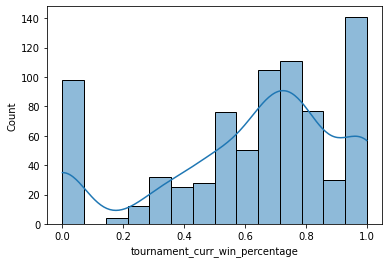

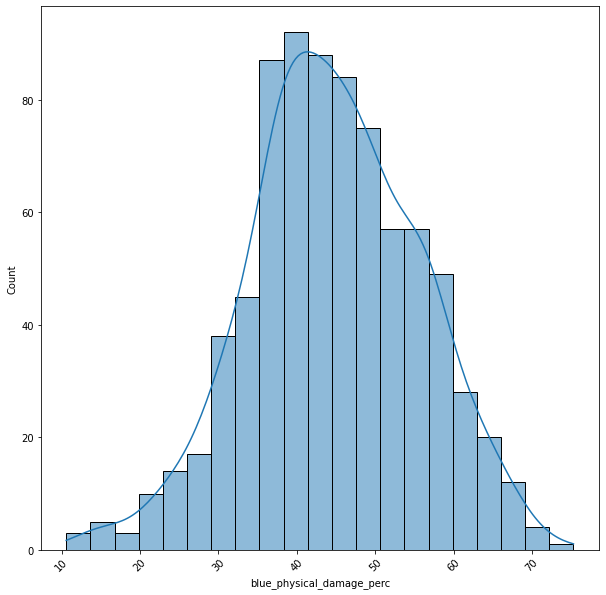

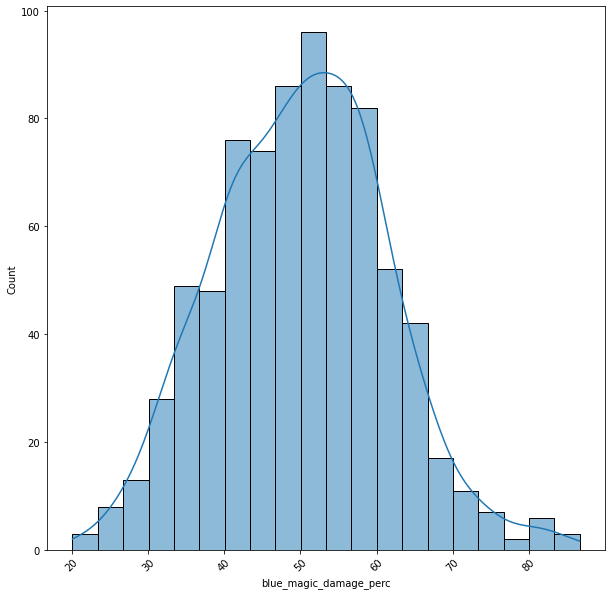

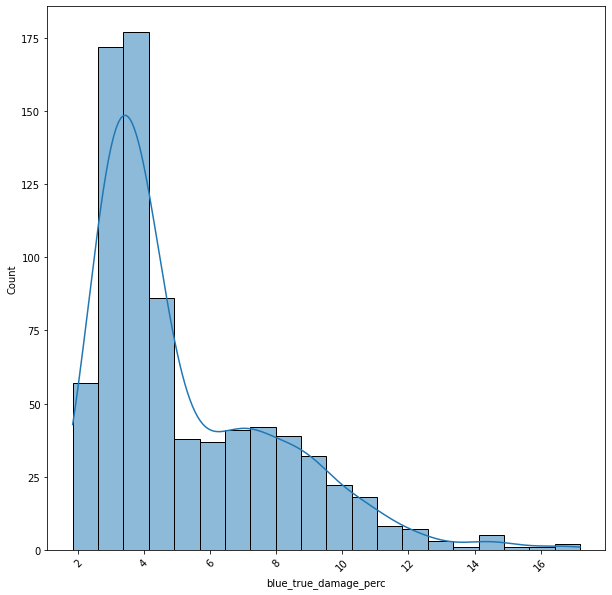

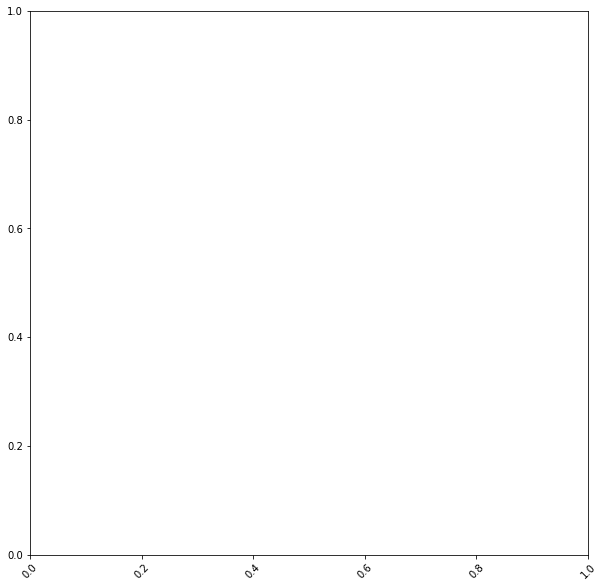

In [138]:
for col in numerical_cols:
    # seaborn.histplot(data=X_train, x=col)
    seaborn.histplot(data=X_train, x=col, kde=True)
    plt.figure(figsize=(10,10))
    plt.xticks(rotation=45)

In [ ]:
categorical_cols

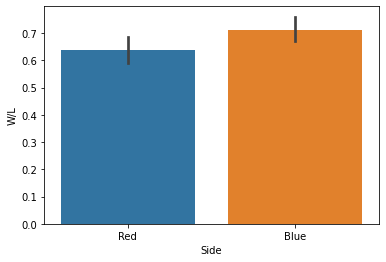

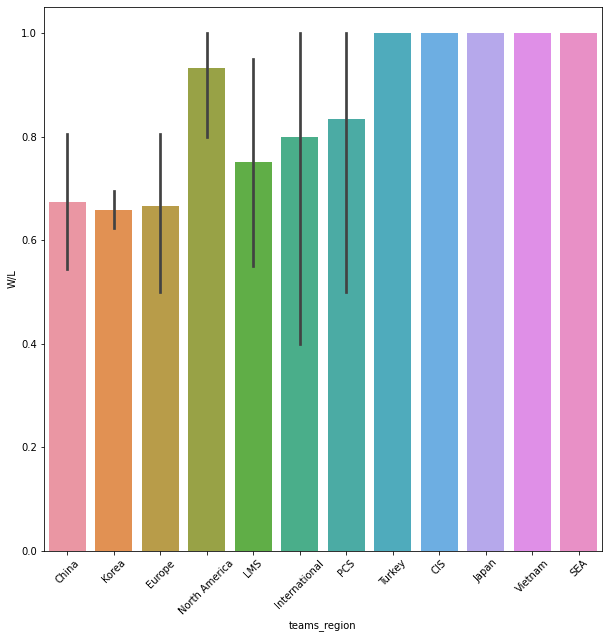

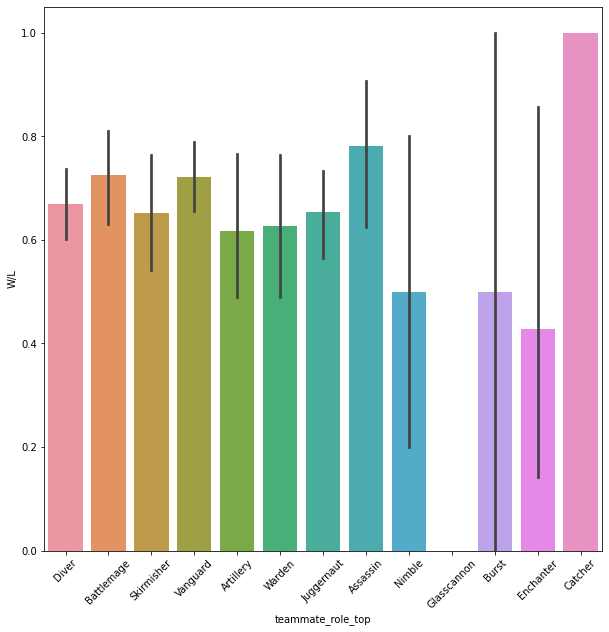

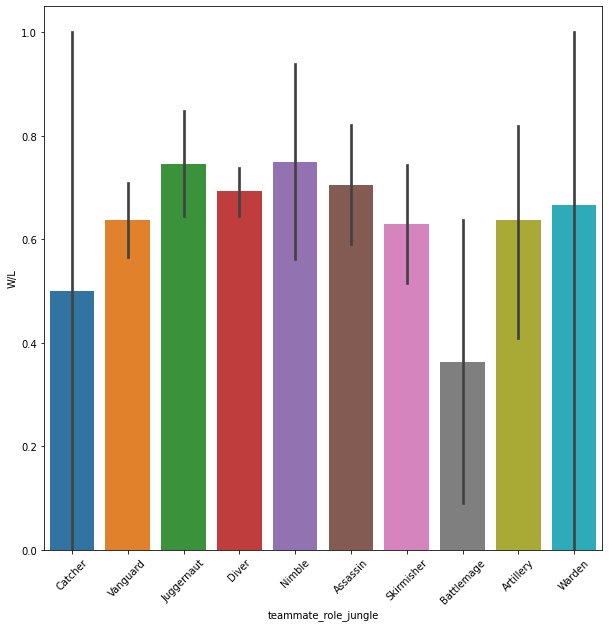

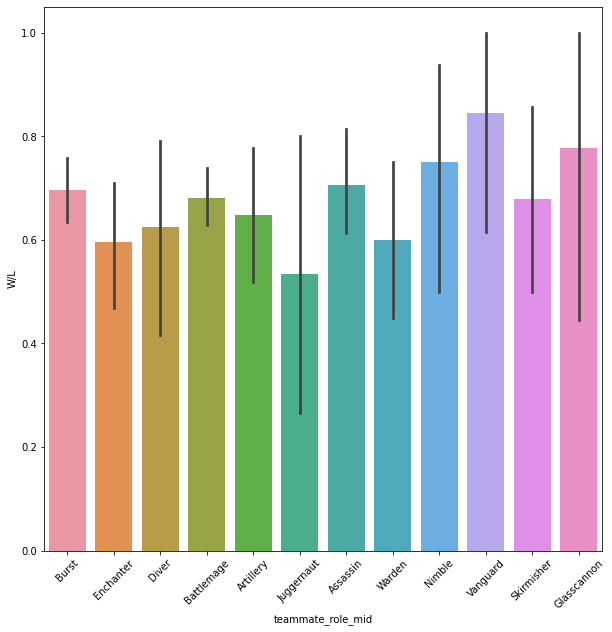

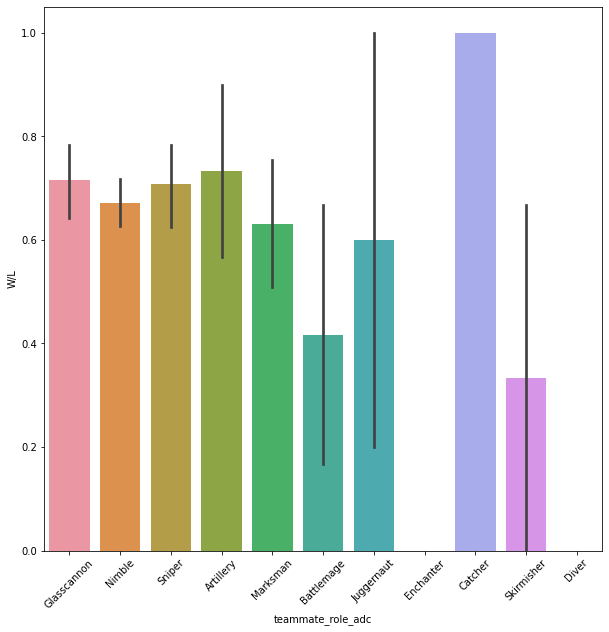

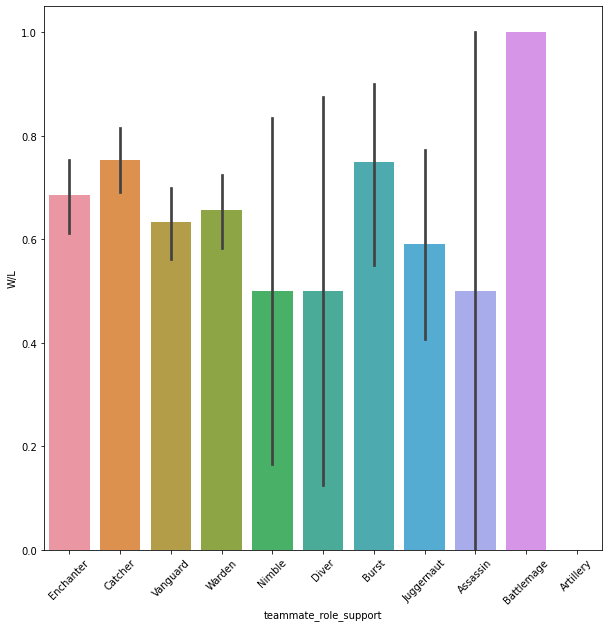

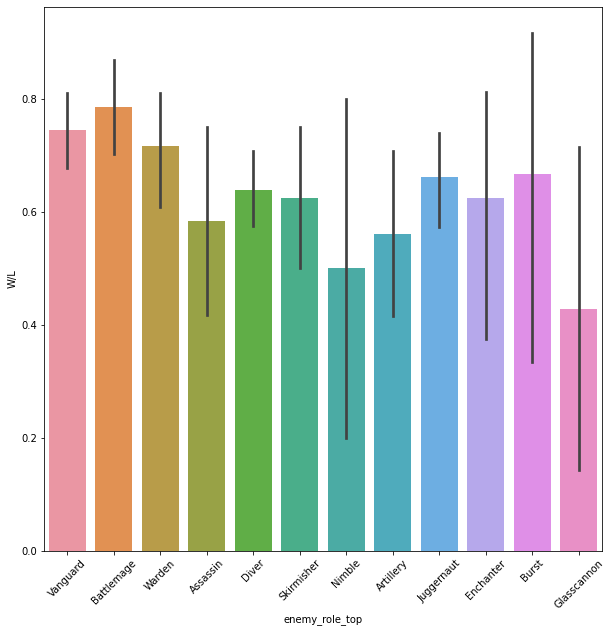

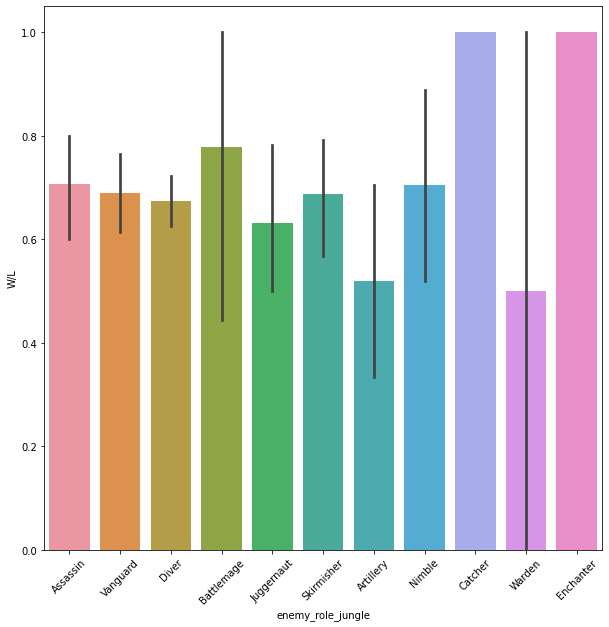

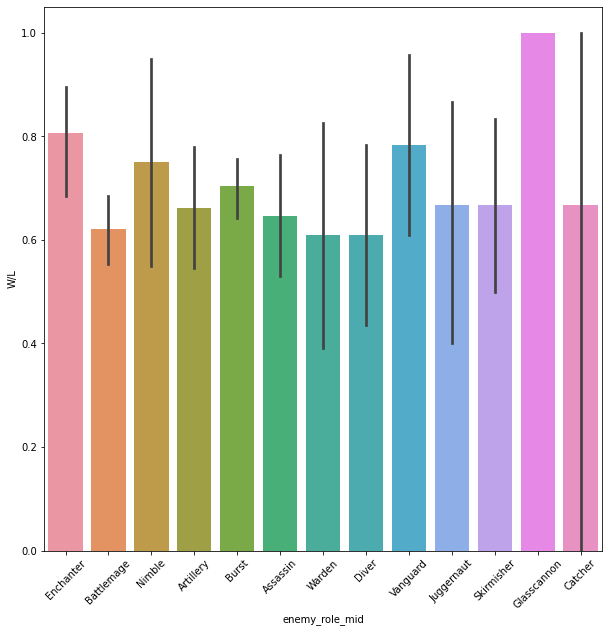

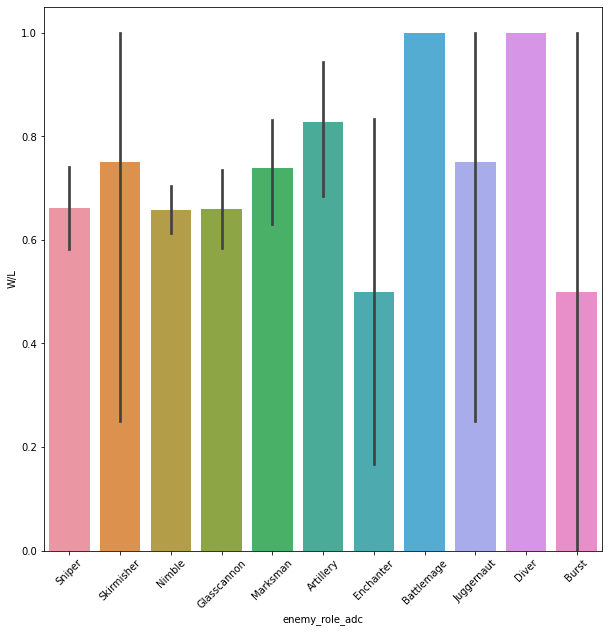

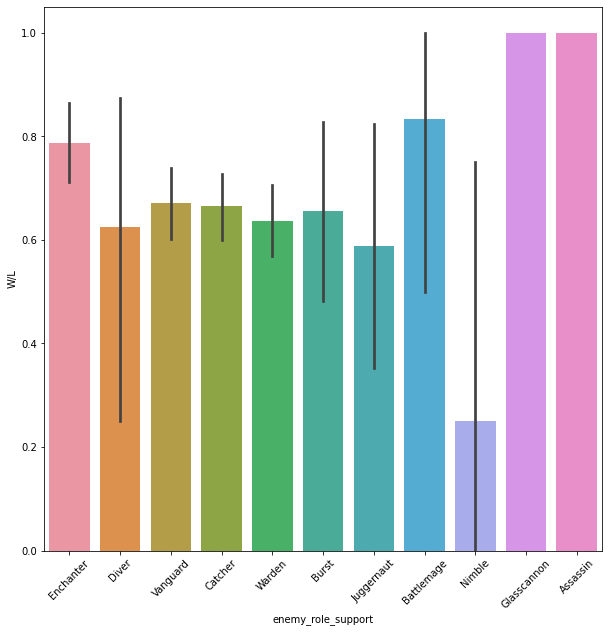

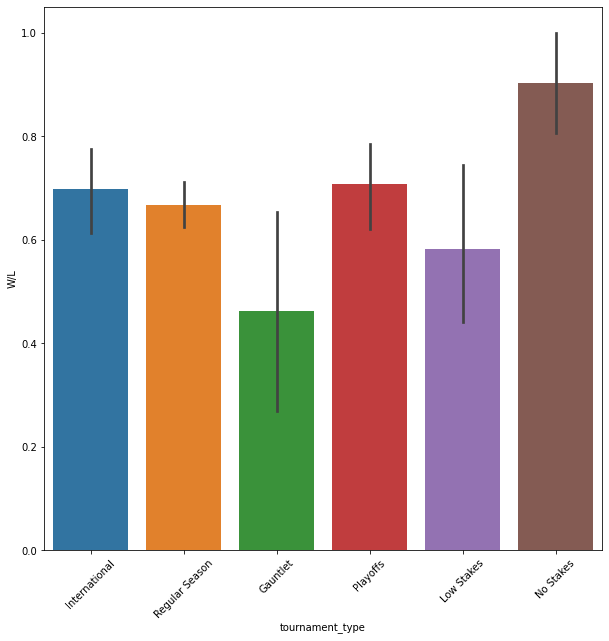

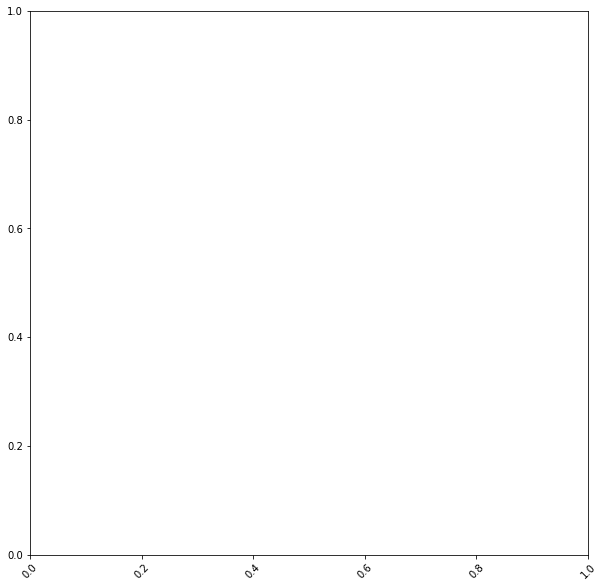

In [536]:
for col in categorical_cols:
    seaborn.barplot(data=X_train, x=col, y=y_train)
    plt.figure(figsize=(10,10))
    plt.xticks(rotation=45)

In [ ]:
print_pandas_no_truncate()
for col in categorical_cols:
    print(X_train.pivot_table(index=y_train, columns=col, aggfunc="size", fill_value=0))
print_pandas_reset()

Error Analysis

In [8]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
# rf = joblib.load("C:\\Users\\Beau\\Desktop\\ML\\faker\\models\\rf_5.pkl")
rf = joblib.load("/home/beaujb/github/faker-classifier/models/rf_5.pkl")

/home/beaujb/github/faker-classifier/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/beaujb/github/faker-classifier/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/beaujb/github/faker-classifier/.venv/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator ColumnTransformer from version 1.0.2 when using version

In [17]:
rf.predict([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [33]:
X_test

,Side,tournament_curr_win_percentage,teams_region,teammate_role_top,teammate_role_jungle,teammate_role_mid,teammate_role_adc,teammate_role_support,enemy_role_top,enemy_role_jungle,enemy_role_mid,enemy_role_adc,enemy_role_support,tournament_type,blue_physical_damage_perc,blue_magic_damage_perc,blue_true_damage_perc,red_physical_damage_perc,red_magic_damage_perc,red_true_damage_perc
712,Blue,0.3077,Korea,Diver,Vanguard,Diver,Marksman,Burst,Artillery,Battlemage,Juggernaut,Nimble,Warden,Regular Season,58.332843,31.696382,9.970774,62.760950,34.303846,3.003665
272,Blue,0.7059,Korea,Vanguard,Skirmisher,Artillery,Nimble,Vanguard,Warden,Diver,Assassin,Nimble,Juggernaut,Regular Season,46.905727,49.697161,3.428536,63.949686,31.795712,4.254603
27,Blue,1.0000,Korea,Vanguard,Vanguard,Burst,Sniper,Enchanter,Battlemage,Assassin,Assassin,Glasscannon,Enchanter,Playoffs,35.965637,60.396715,3.647306,42.252138,49.395099,8.352763
776,Blue,0.4000,Korea,Diver,Diver,Vanguard,Nimble,Catcher,Nimble,Diver,Burst,Nimble,Vanguard,Low Stakes,56.683832,37.964674,5.387840,59.321561,32.701540,7.976899
753,Blue,0.8889,Korea,Diver,Vanguard,Assassin,Nimble,Warden,Diver,Diver,Skirmisher,Sniper,Warden,Playoffs,47.474656,43.747444,8.777900,43.454644,51.092054,5.508669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,Red,0.5000,Korea,Diver,Assassin,Enchanter,Sniper,Enchanter,Skirmisher,Diver,Burst,Nimble,Warden,Regular Season,57.137228,39.894833,2.967939,50.924679,45.811614,3.263707
601,Red,0.2500,Korea,Juggernaut,Vanguard,Skirmisher,Catcher,Assassin,Juggernaut,Diver,Burst,Nimble,Warden,Regular Season,51.857454,38.660341,9.500331,58.239134,27.649088,14.111778
37,Red,0.8125,Korea,Warden,Diver,Assassin,Glasscannon,Catcher,Warden,Assassin,Assassin,Sniper,Catcher,Playoffs,60.497853,36.418764,4.686590,61.176349,28.909683,9.913968
649,Blue,0.6000,Korea,Skirmisher,Diver,Burst,Nimble,Warden,Skirmisher,Vanguard,Battlemage,Sniper,Warden,Regular Season,46.457050,41.926258,11.627554,27.397772,69.530104,3.072124


[[36 33]
 [67 62]]
tn=62


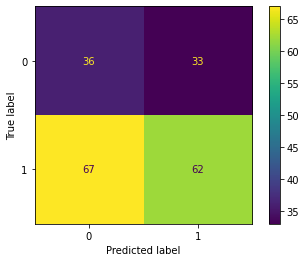

<Figure size 720x720 with 0 Axes>

In [42]:
predictions = rf.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=predictions)
print(cm)
tn, fp, fn, tp = cm.ravel()
print(f"tn={tp}")
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
display.plot()
plt.figure(figsize=(10,10))
plt.show()

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_test, y_pred=predictions))

              precision    recall  f1-score   support

           0       0.35      0.52      0.42        69
           1       0.65      0.48      0.55       129

    accuracy                           0.49       198
   macro avg       0.50      0.50      0.49       198
weighted avg       0.55      0.49      0.51       198



In [50]:
from sklearn.metrics import balanced_accuracy_score, recall_score
y_true = [1, 1, 1, 0, 0, 0]
y_pred = [0, 0, 0, 0, 0, 0]
print(recall_score(y_true, y_pred))
balanced_accuracy_score(y_true, y_pred)
# two classes
# recall respect to 1: (0 / (0 + 0)) => 0.0
# recall respect to 0: (3 / (3 + 0)) => 1.0
# balanced_accuracy_score = (0.0 + 1.0) / two => 0.5

0.0


0.5

In [ ]:
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_colwidth', None)
pandas.set_option('display.max_rows', None)

count = 0
for i, match in X_test.iterrows():
    match = pandas.DataFrame(match).T  # convert 'match':Series to DataFrame (which will have shape (13,1)) and transpose to have shape (1,13) as a compatible datatype for *.predict 
    prediction = rf.predict(match)[0]

    if prediction == y_test.loc[i]:
        continue
    # Type 1 - False Positive
    if prediction == 1 and y_test.loc[i] != prediction:
        print("TYPE 1 ERROR")
    # Type 2 - False Negative
    if prediction == 0 and y_test.loc[i] != prediction:
        print("TYPE 2 ERROR")
    print(match)
    print(dataframe.loc[i])
    count += 1
    if count == 15:
        break
pandas.reset_option('display.max_columns')
pandas.reset_option('display.max_colwidth')
pandas.reset_option('display.max_rows')

Helper Functions

In [ ]:
def print_df_row(row):
    """Print full row details. Resets panda options"""
    # Removes truncations
    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.max_colwidth', None)
    pandas.set_option('display.max_rows', None)

    # Print
    print(row)

    # Reset
    pandas.reset_option('display.max_columns')
    pandas.reset_option('display.max_colwidth')
    pandas.reset_option('display.max_rows')

def print_pandas_no_truncate():
    pandas.set_option('display.max_columns', None)
    pandas.set_option('display.max_colwidth', None)
    pandas.set_option('display.max_rows', None)

def print_pandas_reset():
    pandas.reset_option('display.max_columns')
    pandas.reset_option('display.max_colwidth')
    pandas.reset_option('display.max_rows')

In [35]:
highest_physical_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["physical_damage"], reverse=True)[:10]
highest_physical_damage = {champ: gol_champions[champ]["physical_damage"] for champ in highest_physical_damage}
print(highest_physical_damage)
print()
lowest_physical_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["physical_damage"])[1:10]
lowest_physical_damage = {champ: gol_champions[champ]["physical_damage"] for champ in lowest_physical_damage}
print(lowest_physical_damage)

{'Illaoi': 97.0, 'Kled': 96.6, 'Draven': 95.1, 'Riven': 94.6, 'Aatrox': 94.4, 'Talon': 94.1, 'Sivir': 94.0, 'Senna': 93.6, 'Xayah': 91.9, 'Tryndamere': 91.1}

{'Karthus': 0.6, 'Xerath': 1.0, 'Galio': 1.4, "Vel'Koz": 1.4, 'Viktor': 1.4, 'Cassiopeia': 1.9, 'Brand': 2.2, 'Rumble': 2.3, 'Ziggs': 2.5}


In [36]:
highest_magic_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["magic_damage"], reverse=True)[:10]
highest_magic_damage = {champ: gol_champions[champ]["magic_damage"] for champ in highest_magic_damage}
print(highest_magic_damage)
print()
lowest_magic_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["magic_damage"])[1:10]
lowest_magic_damage = {champ: gol_champions[champ]["magic_damage"] for champ in lowest_magic_damage}
print(lowest_magic_damage)

{'Xerath': 98.0, 'Viktor': 97.5, 'Cassiopeia': 96.7, 'Ziggs': 96.6, 'Singed': 96.1, 'Rumble': 96.0, 'Veigar': 95.8, 'Azir': 95.6, 'Karthus': 95.6, 'Brand': 95.4}

{'Darius': 0.6, 'Kled': 0.6, 'Riven': 0.9, 'Draven': 1.4, 'Talon': 1.4, 'Senna': 1.6, 'Pyke': 1.9, 'Urgot': 2.1, 'Illaoi': 2.2}


In [38]:
highest_true_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["true_damage"], reverse=True)[:10]
highest_true_damage = {champ: gol_champions[champ]["true_damage"] for champ in highest_true_damage}
print(highest_true_damage)
print()
lowest_true_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["true_damage"])[1:10]
lowest_true_damage = {champ: gol_champions[champ]["true_damage"] for champ in lowest_true_damage}
print(lowest_true_damage)

{'Master Yi': 34.2, 'Olaf': 31.7, 'Fiora': 30.4, 'Gwen': 29.7, 'Camille': 26.9, 'Lillia': 26.0, 'Renata Glasc': 25.4, 'Vayne': 25.3, "Bel'Veth": 24.2, 'Sett': 24.2}

{'Nilah': 0, 'Rammus': 0.5, 'Illaoi': 0.8, 'Malphite': 0.8, 'Singed': 0.8, 'Dr. Mundo': 0.9, 'Ziggs': 0.9, 'Maokai': 1.0, 'Nasus': 1.0, 'Ryze': 1}


Damage Type weighted with DPM

In [39]:
highest_physical_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["physical_damage"] * gol_champions[x]["DPM"], reverse=True)[:10]
highest_physical_damage = {champ: gol_champions[champ]["physical_damage"] * gol_champions[champ]["DPM"] / 100 for champ in highest_physical_damage}
print(highest_physical_damage)
print()
lowest_physical_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["physical_damage"])[1:10]
lowest_physical_damage = {champ: gol_champions[champ]["physical_damage"] * gol_champions[champ]["DPM"] / 100 for champ in lowest_physical_damage}
print(lowest_physical_damage)

{'Illaoi': 537.38, 'Sivir': 528.28, 'Jayce': 517.65, 'Xayah': 491.665, 'Quinn': 490.30799999999994, 'Jinx': 478.268, 'Caitlyn': 472.20700000000005, 'Twitch': 463.33099999999996, 'Draven': 462.186, 'Aphelios': 460.8}

{'Karthus': 3.3659999999999997, 'Xerath': 7.43, 'Galio': 4.536, "Vel'Koz": 8.595999999999998, 'Viktor': 8.665999999999999, 'Cassiopeia': 9.215, 'Brand': 10.516000000000002, 'Rumble': 11.936999999999998, 'Ziggs': 17.1}


In [40]:
highest_magic_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["magic_damage"] * gol_champions[x]["DPM"], reverse=True)[:10]
highest_magic_damage = {champ: gol_champions[champ]["magic_damage"] * gol_champions[champ]["DPM"] / 100 for champ in highest_magic_damage}
print(highest_magic_damage)
print()
lowest_magic_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["magic_damage"])[1:10]
lowest_magic_damage = {champ: gol_champions[champ]["magic_damage"] * gol_champions[champ]["DPM"] / 100 for champ in lowest_magic_damage}
print(lowest_magic_damage)

{'Xerath': 728.14, 'Ziggs': 660.7439999999999, 'Viktor': 603.525, 'Heimerdinger': 587.168, 'Karthus': 536.316, 'Azir': 532.492, 'Corki': 507.955, 'Rumble': 498.24, 'Taliyah': 497.596, 'Teemo': 487.816}

{'Darius': 2.01, 'Kled': 2.238, 'Riven': 2.898, 'Draven': 6.803999999999999, 'Talon': 6.075999999999999, 'Senna': 7.344000000000001, 'Pyke': 3.211, 'Urgot': 8.043000000000001, 'Illaoi': 12.188000000000002}


In [41]:
highest_true_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["true_damage"] * gol_champions[x]["DPM"], reverse=True)[:10]
highest_true_damage = {champ: gol_champions[champ]["true_damage"] * gol_champions[champ]["DPM"] / 100 for champ in highest_true_damage}
print(highest_true_damage)
print()
lowest_true_damage = sorted(gol_champions, key=lambda x: gol_champions[x]["true_damage"])[1:10]
lowest_true_damage = {champ: gol_champions[champ]["true_damage"] * gol_champions[champ]["DPM"] / 100 for champ in lowest_true_damage}
print(lowest_true_damage)

{'Master Yi': 142.95600000000002, 'Gwen': 138.69899999999998, "Vel'Koz": 131.396, 'Fiora': 130.72, 'Ahri': 119.05400000000002, 'Vayne': 116.63300000000001, 'Lillia': 104.52, 'Camille': 99.79899999999999, 'Olaf': 96.685, 'Twitch': 92.897}

{'Rammus': 2.055, 'Illaoi': 4.432, 'Malphite': 2.8640000000000003, 'Singed': 2.968, 'Dr. Mundo': 3.762, 'Ziggs': 6.156000000000001, 'Maokai': 3.61, 'Nasus': 4.94, 'Ryze': 4.31}


In [85]:
# Verify damage profile sums to 100
print("GOL Data last updated on 20220731")
for champ, info in gol_champions.items():
    total = 0
    for k, v in info.items():
        if 'damage' in k:
            total += v
    if total < 99.999 and total != 0:
        print(f"{champ} has total={total}")
    if total == 0:
        print(f"No data on {champ}.")

GOL Data last updated on 20220731
No data on Nilah.
